In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(cons_of_max, lens):    
    if cons_of_max == 3 and lens < 115 and lens > 98:
        return "c"
    elif cons_of_max == 2 and lens < 95 and lens > 80:
        return "t"
    else:
        return "ucf"
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_dist = vector_dist(cv, cv2)
        total_separations += vector_dist
        if vector_dist <= 2*radius: # blob centers closer than diameter of one blob
            num_connections += 1
        else:
            pass
        normalized_dists.append(vector_dist/(2*norm_radius))
    return (num_connections, normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
connect_test = connect((0, 0),2, [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

(2, [0.1, 0.1414213562373095, 0.0, 0.4242640687119285], 19.97056274847714) [5.0, 10.0] hello


In [4]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    max_rad = 15*1.35
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        highlight = morphology.opening(thresh_img, square(7))
        img = np.copy(frame)
        img[highlight==0] = 0
        blobs =skimage.feature.blob_doh(img, min_sigma = 6, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.8)
        blobset.append(blobs)
        
        num_connections = 0
        plas_connections = 0
        glas_connections = 0
        both_connections = 0
        
        blobs = sorted(blobs, key = third_item, reverse=True)
        num_blobs = len(blobs)
        plas_blobs = blobs[0:2]
        glas_blobs = blobs[-3:-1]
        
        plas_on_glas_dists =[connect((pblob[1], pblob[0]),max_rad, glas_blobs) for pblob in plas_blobs]
        plas_on_glas_dists = [plas_on_glas_dists[0][0]+ plas_on_glas_dists[1][0], 
                              plas_on_glas_dists[0][1].extend(plas_on_glas_dists[1][1]),
                             plas_on_glas_dists[0][2]+ plas_on_glas_dists[1][2]]
        glas_on_glas_dists = [connect((glas_blobs[0][1], glas_blobs[0][0]),max_rad,
                                      (glas_blobs[1][1], glas_blobs[1][0]))]
        plas_on_plas_dists = [connect((plas_blobs[0][1], plas_blobs[0][0]),max_rad,
                                      (plas_blobs[1][1], plas_blobs[1][0]))]
        cons_of_max = connect_dists[0]
        num_connections +=cons_of_max 
        distances = connect_dists[1]
        length_of_transparents=0
        num_smaller_blobs = num_blobs - 1
        for i in range(num_smaller_blobs-1):
            blob = blobs[i+1]
            center_vec = (blob[1], blob[0])
            connect_dists = connect(center_vec, max_rad, blobs[i+2::])
            num_connections += connect_dists[0]
            length_of_transparents += connect_dists[2]
            distances.extend(connect_dists[1])
        #----------------------filter------------------------- can use actual filter
        properties = [num_blobs, num_connections, cons_of_max, length_of_transparents, distances]
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = (num_blobs == expected_blobs
                and num_connections == expected_connections 
               )
        if test:  
            if (cons_of_max == 3 or cons_of_max == 2):
                #-----------------------------classify pt 1---------------------------------------
                clas = sideify(cons_of_max, length_of_transparents )
                filtrate_prop.append(properties)
            else:
                clas = 'ucf'
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [16]:
filenames = filename = glob("./tchakamau/half*/*[1][0]v*[1,3,4,5].avi")#glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 4
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"p" : list(range(59749, 52563, -31)),
                  "g" :[], 
                  "b" :list(range(39616, 38090, -6)),
                 "broken" :list(range(52344, 52116, -1)) ,
                 "odd_s" :list(chain(range(52116,51886, -2), range(28051, 27873, -2))) }
phantom_frames_2 = {"p" : list(range(46297, 45476, -3)),
                  "g" :list(range(43467, 41900, -3)), 
                  "b" :[],
                 "broken" :[],
                 "odd_s" :list(chain(range(41855, 41653, -3), range(43599,43536-1), range(44756, 44444, -3),
                                     range(45458, 45305, -1)))}
phantom_frames_3 = {"p" : list(range(21944, 10399, -28)),
                  "g" :list(range(57193, 50565, -22)), 
                  "b" :list(range(78900, 77197, -4)),
                 "broken" :list(range(66444, 66101, -2)) ,
                 "odd_s" :list(chain(range(81731, 79275, -30), range(75189, 74345, -9), range(66080, 65836, -2))) }
phantom_frames_4 = {"p" : [],
                  "g" :[], 
                  "b" :list(range(22544, 20834, -8)),
                 "broken" :list(chain(range(17541, 17193, -3), range(12284, 11756, -3))) ,
                 "odd_s" :[]}

phantom_frame_sets = [phantom_frames,phantom_frames_2,phantom_frames_3, phantom_frames_4]
trigger_frames = [58749, 85587,85587,22544]#[13268, 18192, 2964, 8535]


['./tchakamau\\HalfHalf\\45592_10Vpp_1.avi', './tchakamau\\HalfHalf\\45652_10Vpp_3.avi', './tchakamau\\HalfHalf\\45655_10Vpp_4.avi', './tchakamau\\HalfHalf\\45682_10Vpp_5.avi']


In [17]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["p", "g", "b", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if tf-frameindex in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], tf-frameindex))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x000002075DDE85E8>
<generator object vreader at 0x0000020710CF01B0>
<generator object vreader at 0x0000020715A2FC00>
<generator object vreader at 0x0000020715A2FB88>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [18]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[2])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[1])
    print(orig, len(filtrates_props[i]), len(x[1]))
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", fil*100/orig)
        p_rats.append(fil*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

915 0 0
p _vid
original_vid:  915
filtrate:  0
pass ratio:  0.0


825 0 0
g _vid
original_vid:  825
filtrate:  0
pass ratio:  0.0


895 39 0
b _vid
original_vid:  895
filtrate:  0
pass ratio:  0.0


1031 0 1031
odd_s _vid
original_vid:  1031
filtrate:  1031
pass ratio:  100.0


692 2 692
broken _vid
original_vid:  692
filtrate:  692
pass ratio:  100.0


5 5 5


num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
num_blobs variances: 
p : 1 
g : 0 
b : 1 
odd_s : 1 


IndexError: list index out of range

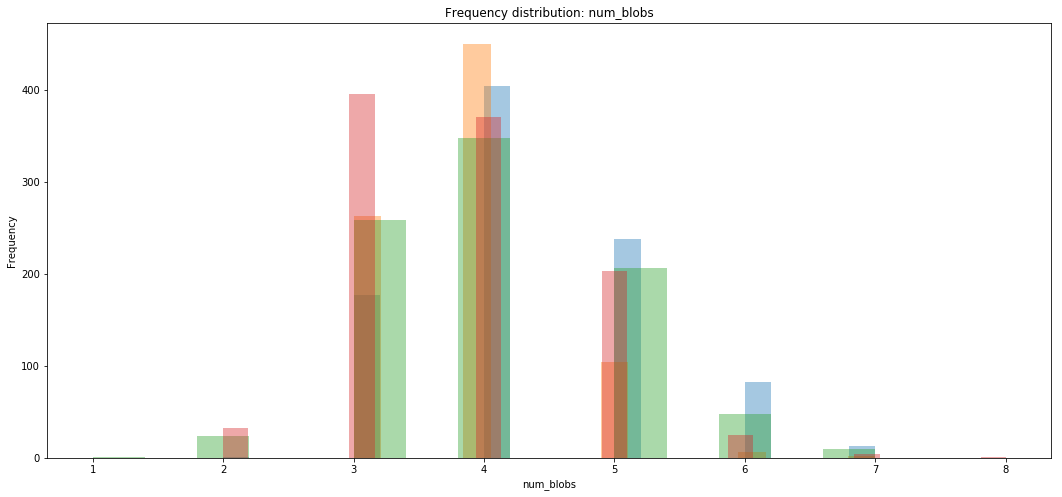

In [19]:
"""FINDING CORRECT THRESHOLDS FOR SEPARATING BROKEN AND ODD SHAPED FRAMES"""

# use area information from properties


propnames = ['num_blobs', 'num_connections', 'cons_of_max', 'length_of_transparents']
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [h[k] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
klist = []
for i in range(num_shape_cats):
    x = [d for lis in [h[4] for h in a_props[i]] for d in lis]
    klist.append(x) #list of areas for every category
print(len(klist[0]))
print("distances averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
print("distances variances: " )
[print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: " +  'distances')
plt.xlabel( 'distances')
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = klist[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




In [ ]:
"""After first tests"""
# use area information from properties


propnames = ['num_blobs', 'num_connections', 'cons_of_max', 'length_of_transparents']
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [h[k] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
print(len(klist[0]))
klist = []
for i in range(num_shape_cats):
    x = [d for lis in [h[4] for h in filtrates_props[i]] for d in lis]
    klist.append(x) #list of areas for every category
print(len(klist[0]))
print("distances averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
print("distances variances: " )
[print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: " +  'distances')
plt.xlabel( 'distances')
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = klist[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

In [ ]:

"""Correctly classified"""
# use area information from properties


propnames = ['num_blobs', 'num_connections', 'cons_of_max', 'length_of_transparents']
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [h[k] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    
    
    
print(len(klist[0]))
klist = []
for i in range(num_shape_cats):
    x = [d for lis in [h[4] for h in passes[i]] for d in lis]
    klist.append(x) #list of areas for every category
print(len(klist[0]))
print("distances averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
print("distances variances: " )
[print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
fig, ax = plt.subplots(figsize=(18,8))
#plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: " +  'distances')
plt.xlabel( 'distances')
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = klist[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])